This is an attempted re-creation of the resonance example given in the documentation for the REBOUND code, Results may not be correct.

In [27]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


sim = rebound.Simulation()
sim.units = ('AU', 'days', 'Msun')

# We can add Jupiter and four of its moons by name, since REBOUND is linked to the HORIZONS database.
labels = ["Jupiter", "Io", "Europa","Ganymede","Callisto"]
sim.add(labels)

Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Io'... 
Found: Io (501) (chosen from query 'Io')
Searching NASA Horizons for 'Europa'... 
Found: Europa (502) (chosen from query 'Europa')
Searching NASA Horizons for 'Ganymede'... 
Found: Ganymede (503) 
Searching NASA Horizons for 'Callisto'... 
Found: Callisto (504) 


In [28]:
os = sim.calculate_orbits()
print("n_i (in rad/days) = %6.3f, %6.3f, %6.3f" % (os[0].n,os[1].n,os[2].n))
print("P_i (in days)     = %6.3f, %6.3f, %6.3f" % (os[0].P,os[1].P,os[2].P))

n_i (in rad/days) =  3.546,  1.771,  0.879
P_i (in days)     =  1.772,  3.548,  7.147


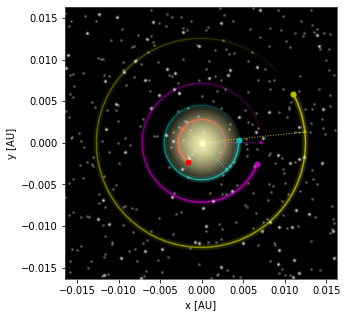

In [29]:
sim.move_to_com()
fig = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True, fancy=True)

In [30]:
sim.integrator = "whfast"
sim.dt = 0.05 * os[0].P  # 5% of Io's period
Nout = 100000            # number of points to display
tmax = 80*365.25         # let the simulation run for 80 years
Nmoons = 4

In [31]:
x = np.zeros((Nmoons,Nout))
ecc = np.zeros((Nmoons,Nout))
longitude = np.zeros((Nmoons,Nout))
varpi = np.zeros((Nmoons,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

for i,time in enumerate(times):
    sim.integrate(time)
    # note we use integrate() with the default exact_finish_time=1, which changes the timestep near 
    # the outputs to match the output times we want.  This is what we want for a Fourier spectrum, 
    # but technically breaks WHFast's symplectic nature.  Not a big deal here.
    os = sim.calculate_orbits()
    for j in range(Nmoons):
        x[j][i] = ps[j+1].x 
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        varpi[j][i] = os[j].Omega + os[j].omega

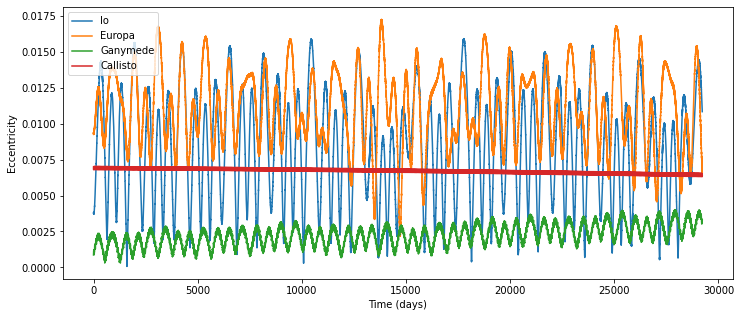

In [32]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[1])
plt.plot(times,ecc[1],label=labels[2])
plt.plot(times,ecc[2],label=labels[3])
plt.plot(times,ecc[3],label=labels[4])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Eccentricity")
plt.legend();

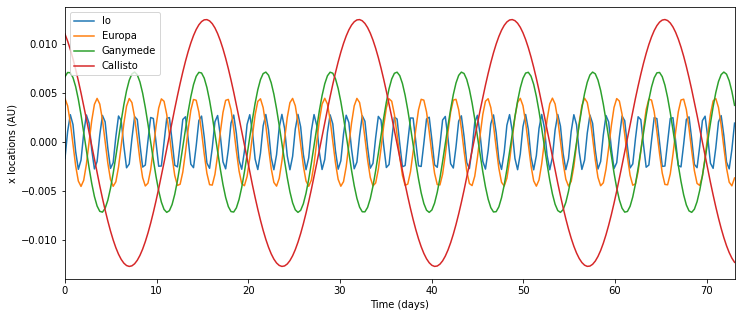

In [33]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,x[0],label=labels[1])
plt.plot(times,x[1],label=labels[2])
plt.plot(times,x[2],label=labels[3])
plt.plot(times,x[3],label=labels[4])
ax.set_xlim(0,0.2*365.25)
ax.set_xlabel("Time (days)")
ax.set_ylabel("x locations (AU)")
ax.tick_params()
plt.legend();

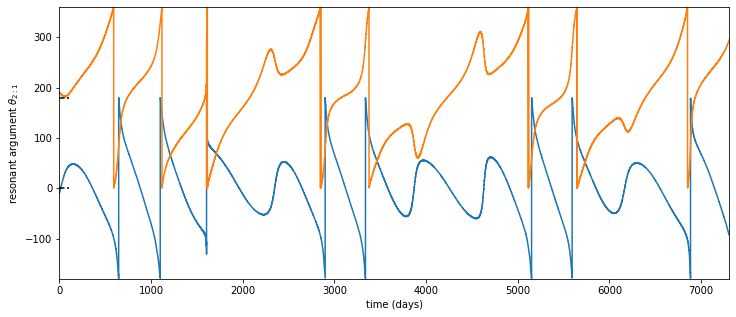

In [34]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

# We can calculate theta, the resonant argument of the 1:2 Io-Europa orbital resonance,
# which oscillates about 0 degrees:
theta = [min180To180(2.*longitude[1][i] - longitude[0][i] - varpi[0][i]) for i in range(Nout)]

# There is also a secular resonance argument, corresponding to the difference in the longitude of perihelions:
# This angle oscillates around 180 degs, with a longer period component.
theta_sec = [zeroTo360(-varpi[1][i] + varpi[0][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,theta)  
ax.plot(times,theta_sec) # secular resonance argument
ax.set_xlim([0,20.*365.25])
ax.set_ylim([-180,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"resonant argument $\theta_{2:1}$")
ax.plot([0,100],[180,180],'k--')
ax.plot([0,100],[0,0],'k--')

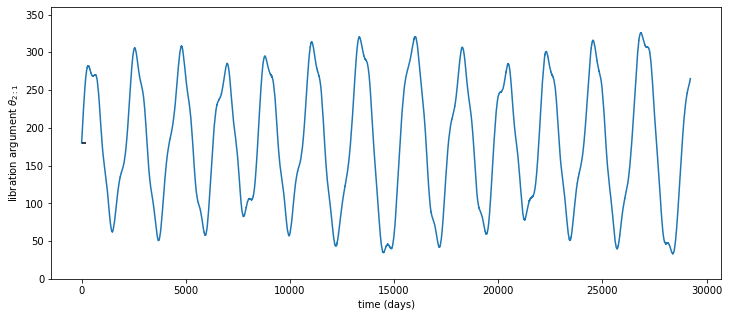

In [35]:
thetaL = [zeroTo360(-longitude[0][i] + 3.*longitude[1][i] - 2.*longitude[2][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

ax.plot(times,thetaL)
ax.set_ylim([0,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"libration argument $\theta_{2:1}$")
ax.plot([0,200],[180,180],'k--')

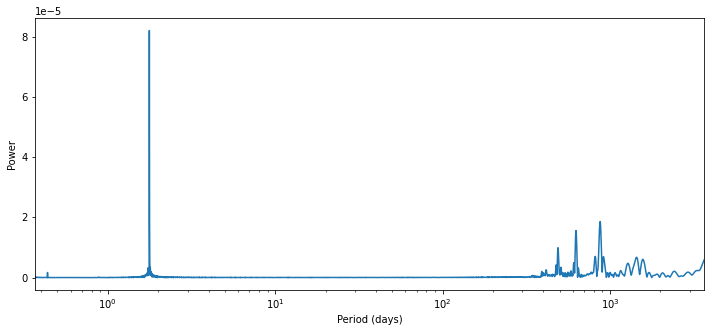

In [36]:
from scipy import signal
Npts = 3000

# look for periodicities with periods logarithmically spaced between 0.01 yrs and 100 yrs
logPmin = np.log10(0.001*365.25)
logPmax = np.log10(10.*365.25)

# set up a logspaced array from 0.01 to 100 yrs
Ps = np.logspace(logPmin,logPmax,Npts)
# calculate an array of corresponding angular frequencies
ws = np.asarray([2*np.pi/P for P in Ps])

# calculate the periogram (for Io) (using ws as the values for which to compute it)
periodogram = signal.lombscargle(times,x[0],ws)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)

# Since the computed periodogram is unnormalized, taking the value A**2*N/4, 
# we renormalize the results by applying these functions inversely to the output:
ax.set_xscale('log')
ax.set_xlim([10**logPmin,10**logPmax])
ax.set_xlabel("Period (days)")
ax.set_ylabel("Power")
ax.plot(Ps,np.sqrt(4*periodogram/Nout))